<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C3/W3/ungraded_labs/C3_W3_Lab_5_sarcasm_with_bi_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Training a Sarcasm Detection Model using Bidirectional LSTMs

In this lab, you will revisit the [News Headlines Dataset for Sarcasm Detection](https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection/home) dataset and use it to train a Bi-LSTM Model.


In [1]:
# Install this package to use Colab's GPU for training
!apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 27 not upgraded.
Need to get 420 MB of archives.
After this operation, 1,622 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.4.1.50-1+cuda11.6 [420 MB]
Fetched 420 MB in 11s (38.8 MB/s)
(Reading database ... 123942 files and directories currently installed.)
Removing libcudnn8-dev (8.1.1.33-1+cuda11.2) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
(Reading database ... 123919 files and directories currently installed.)
Prepar

## Download the Dataset

First, you will download the JSON file and extract the contents into lists.

In [2]:
# Download the dataset
!wget -P data/ https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json

--2022-10-28 20:59:04--  https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 74.125.200.128, 74.125.68.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘data/sarcasm.json’

sarcasm.json        100%[===================>]   5.38M  15.9MB/s    in 0.3s    

2022-10-28 20:59:06 (15.9 MB/s) - ‘data/sarcasm.json’ saved [5643545/5643545]



In [3]:
import json

# Load the JSON file
with open("./data/sarcasm.json", "r") as f:
    datastore = json.load(f)

# Initialize the lists
sentences = []
labels = []

# Collect sentences and labels into the lists
for item in datastore:
    sentences.append(item["headline"])
    labels.append(item["is_sarcastic"])

## Split the Dataset

You will then split the lists into train and test sets.

In [4]:
training_size = 20000

# Split the sentences
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]

# Split the labels
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [5]:
training_sentences[0]

"former versace store clerk sues over secret 'black code' for minority shoppers"

In [6]:
training_labels[0]

0

## Data preprocessing

Next, you will generate the vocabulary and padded sequences.

In [7]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
max_length = 120
trunc_type = "post"
padding_type = "post"
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(
    training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type
)

# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(
    testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type
)

# Convert the labels lists into numpy arrays
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

## Build and Compile the Model

The architecture here is almost identical to the one you used in the previous lab with the IMDB Reviews. Try to tweak the parameters and see how it affects the training time and accuracy (both training and validation).

In [9]:
import tensorflow as tf

# Parameters
embedding_dim = 16
lstm_dim = 32
dense_dim = 24

# Model Definition with LSTM
model_lstm = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
        tf.keras.layers.Dense(dense_dim, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

# Set the training parameters
model_lstm.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Print the model summary
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               12544     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 24)                1560      
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 174,129
Trainable params: 174,129
Non-trainable params: 0
_________________________________________________________________


## Train the Model

In [10]:
NUM_EPOCHS = 10

# Train the model
history_lstm = model_lstm.fit(
    training_padded,
    training_labels,
    epochs=NUM_EPOCHS,
    validation_data=(testing_padded, testing_labels),
)

Epoch 1/10
625/625 [==============================] - 14s 14ms/step - loss: 0.4139 - accuracy: 0.7944 - val_loss: 0.3377 - val_accuracy: 0.8532
Epoch 2/10
625/625 [==============================] - 8s 13ms/step - loss: 0.2132 - accuracy: 0.9125 - val_loss: 0.3610 - val_accuracy: 0.8553
Epoch 3/10
625/625 [==============================] - 9s 15ms/step - loss: 0.1261 - accuracy: 0.9521 - val_loss: 0.4250 - val_accuracy: 0.8557
Epoch 4/10
625/625 [==============================] - 8s 13ms/step - loss: 0.0782 - accuracy: 0.9728 - val_loss: 0.5227 - val_accuracy: 0.8453
Epoch 5/10
625/625 [==============================] - 9s 14ms/step - loss: 0.0469 - accuracy: 0.9847 - val_loss: 0.7006 - val_accuracy: 0.8393
Epoch 6/10
625/625 [==============================] - 8s 13ms/step - loss: 0.0305 - accuracy: 0.9904 - val_loss: 0.8488 - val_accuracy: 0.8374
Epoch 7/10
625/625 [==============================] - 8s 12ms/step - loss: 0.0306 - accuracy: 0.9896 - val_loss: 0.8104 - val_accuracy: 0.836

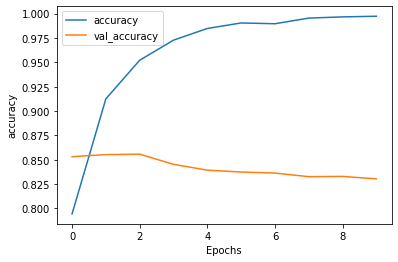

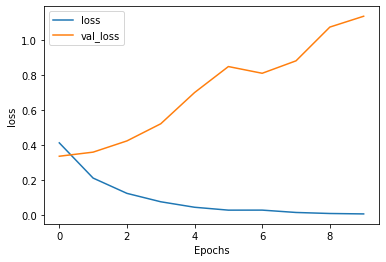

In [11]:
import matplotlib.pyplot as plt

# Plot Utility
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history["val_" + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, "val_" + string])
    plt.show()


# Plot the accuracy and loss history
plot_graphs(history_lstm, "accuracy")
plot_graphs(history_lstm, "loss")

## Build and Compile the *Updated* Model

Multilayer BiLSTM w/ Dropout.

In [12]:
embedding_dim = 16
lstm_dim = 32
dense_dim = 24

# Model Definition with LSTM
model_lstm = tf.keras.Sequential(
    [
        tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(lstm_dim, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)
        ),
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(lstm_dim, dropout=0.5, recurrent_dropout=0.5)
        ),
        tf.keras.layers.Dense(dense_dim, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

# Set the training parameters
model_lstm.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Print the model summary
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 120, 64)          12544     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 24)                1560      
                                                                 
 dense_5 (Dense)             (None, 1)                 25        
                                                                 
Total params: 198,961
Trainable params: 198,961
Non-tr

In [14]:
NUM_EPOCHS = 10

# Train the model
history_lstm = model_lstm.fit(
    training_padded,
    training_labels,
    epochs=NUM_EPOCHS,
    batch_size=512,
    validation_data=(testing_padded, testing_labels),
)

Epoch 1/10
40/40 [==============================] - 92s 2s/step - loss: 0.6825 - accuracy: 0.5603 - val_loss: 0.6657 - val_accuracy: 0.5633
Epoch 2/10
40/40 [==============================] - 82s 2s/step - loss: 0.4831 - accuracy: 0.7610 - val_loss: 0.3599 - val_accuracy: 0.8420
Epoch 3/10
40/40 [==============================] - 84s 2s/step - loss: 0.2804 - accuracy: 0.8860 - val_loss: 0.3379 - val_accuracy: 0.8536
Epoch 4/10
40/40 [==============================] - 81s 2s/step - loss: 0.2326 - accuracy: 0.9084 - val_loss: 0.3728 - val_accuracy: 0.8492
Epoch 5/10
40/40 [==============================] - 84s 2s/step - loss: 0.1968 - accuracy: 0.9236 - val_loss: 0.3636 - val_accuracy: 0.8539
Epoch 6/10
40/40 [==============================] - 81s 2s/step - loss: 0.1648 - accuracy: 0.9373 - val_loss: 0.3897 - val_accuracy: 0.8502
Epoch 7/10
40/40 [==============================] - 84s 2s/step - loss: 0.1501 - accuracy: 0.9438 - val_loss: 0.3984 - val_accuracy: 0.8490
Epoch 8/10
40/40 [==

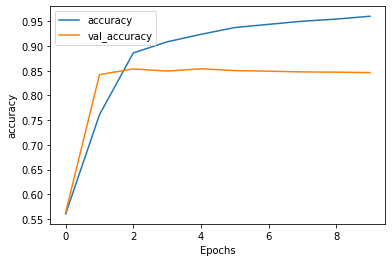

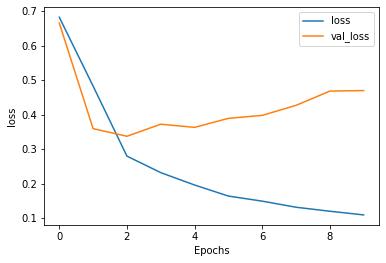

In [15]:
import matplotlib.pyplot as plt

# Plot Utility
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history["val_" + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, "val_" + string])
    plt.show()


# Plot the accuracy and loss history
plot_graphs(history_lstm, "accuracy")
plot_graphs(history_lstm, "loss")